In [1]:
import numpy as np
from PIL import Image

def read_images(file_paths):
    X = []
    y = [] # 0 if sober, 1 if drunk
    
    for file_name in file_paths:
        thermal_data = np.zeros((128, 160))
        with Image.open(file_name) as img:
            for i in range(img.n_frames):
                img.seek(i)
                frame_data = np.array(img)
                min_val = np.amin(frame_data)
                frame_data -= min_val
                for j in range(img.height):
                    for k in range(img.width):
                        thermal_data[j, k] += frame_data[j, k]
        X.append(thermal_data)
        
        if '_1_f' in file_name: # Only first pic in series is sober data
            y.append(0)
        else:
            y.append(1)

        print(file_name)
        print(thermal_data)
    return X,y

In [2]:
import os
import glob
import matplotlib as plt

DIR_NAME = 'data'

os.chdir(f'../{DIR_NAME}')
DATA_DIR = os.getcwd()

In [3]:
os.chdir(os.path.join(DATA_DIR,'train'))
HOME = os.getcwd()

import pickle

X_train = None
y_train = None
if os.path.exists('train.pkl'):
    (X_train,y_train) = pickle.load(open('train.pkl', 'rb'))

else:
    # Full filepaths
    file_paths = []
    subjects = glob.glob('*')
    for subject in subjects:
        for i in range(1,5):
            facial_pics = glob.glob(f'{subject}/*{i}_f*') # Look for only face pictures, labeled 1-4
            for partial_path in facial_pics:
                file_paths.append(os.path.join(HOME,partial_path))
            if not facial_pics:
                print(f'{subject}/{i}_f file not found')

    X_train,y_train = read_images(file_paths)
    pickle.dump((X_train,y_train), open('train.pkl', 'wb'))

In [4]:
os.chdir(os.path.join(DATA_DIR,'test'))
HOME = os.getcwd()

X_test = None
y_test = None
if os.path.exists('test.pkl'):
    (X_test,y_test) = pickle.load(open('test.pkl', 'rb'))

else:
    # Full filepaths
    file_paths = []
    subjects = glob.glob('*')
    for subject in subjects:
        for i in range(1,5):
            facial_pics = glob.glob(f'{subject}/*{i}_f*') # Look for only face pictures, labeled 1-4
            for partial_path in facial_pics:
                file_paths.append(os.path.join(HOME,partial_path))
            if not facial_pics:
                print(f'{subject}/{i}_f file not found')

    X_test,y_test = read_images(file_paths)
    pickle.dump((X_test,y_test), open('test.pkl', 'wb'))

In [5]:
os.chdir(os.path.join(DATA_DIR,'validation'))
HOME = os.getcwd()

X_val = None
y_val = None
if os.path.exists('validation.pkl'):
    (X_val,y_val) = pickle.load(open('validation.pkl', 'rb'))

else:
    # Full filepaths
    file_paths = []
    subjects = glob.glob('*')
    for subject in subjects:
        for i in range(1,5):
            facial_pics = glob.glob(f'{subject}/*{i}_f*') # Look for only face pictures, labeled 1-4
            for partial_path in facial_pics:
                file_paths.append(os.path.join(HOME,partial_path))
            if not facial_pics:
                print(f'{subject}/{i}_f file not found')

    X_val,y_val = read_images(file_paths)
    pickle.dump((X_val,y_val), open('validation.pkl', 'wb'))

In [6]:
len(y_val)

24

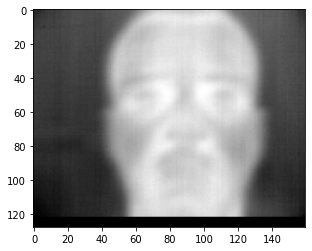

In [7]:
from matplotlib import pyplot

pyplot.imshow(X_train[0], cmap='gray')

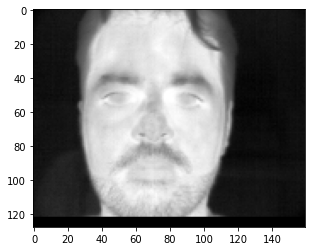

In [8]:
pyplot.imshow(X_train[84], cmap='gray')

In [9]:
import tensorflow as tf

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)
X_val = tf.keras.utils.normalize(X_val, axis=1)

In [10]:
# Attempt at facial recognition

# import cv2
# HOME = os.getcwd()
# face_cascade = cv2.CascadeClassifier(os.path.join(HOME,'haarcascade_frontalface_alt2.xml'))

# img = X_train[0]*255
# img = np.array(img, dtype='uint8')

# # detect
# faces = face_cascade.detectMultiScale(img, minSize=(50,100), scaleFactor=1.05, minNeighbors=0, flags=cv2.CASCADE_SCALE_IMAGE)

# face_roi = None
# # draw boxes around ROI
# for (x,y,w,h) in faces:
#     face_roi = img[y:y+h,x:x+w]
#     cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255), 4)
    

# display(Image.fromarray(img))
# if face_roi:
#     display(Image.fromarray(face_roi))

In [11]:
# Shuffle X_train and y_train together
from sklearn.utils import shuffle

a = ['a', 'b', 'c','d','e']
b = [1, 2, 3, 4, 5]

X_train_s, y_train_s = shuffle(X_train, y_train)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow.keras.metrics

model = Sequential()

x,y = X_train.shape[1:]
model.add(Conv2D(256, (3, 3), input_shape=(x,y,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

METRICS = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'), 
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

input_data = X_train_s.reshape((-1, x, y, 1))
val_data = X_val.reshape((-1, x, y, 1))

# Treat every sober image with same weight as 3 drunk images
class_weight = {0: 1, 1: 3}

model.fit(input_data, np.array(y_train_s), 
          batch_size=32, 
          epochs=50, 
          validation_data=(val_data,np.array(y_val)), 
          class_weight=class_weight,
          use_multiprocessing=True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 103 samples, validate on 24 samples
Epoch 1/50
 32/103 [========>.....................] - ETA: 6s - loss: 1.5600 - accuracy: 0.3125

In [30]:
test_data = X_test.reshape((-1, x, y, 1))
val_loss, val_acc = model.evaluate(test_data, np.array(y_test))
print(val_loss)
print(val_acc)

predictions = model.predict(test_data)

35/35 [==============================] - 1s 26ms/sample - loss: 0.5847 - accuracy: 0.7429
0.5847239396401814
0.74285716


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_pred = []
predictions = model.predict(test_data)
for predict in predictions:
    y_pred.append(int(round(predict[0])))

accuracy_score(y_test,y_pred)

0.7428571428571429

In [32]:
for actual,pred in zip(y_test,y_pred):
    print(f'Actual: {actual}, Pred: {pred}')

Actual: 0, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 0, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 0, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 0, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 0
Actual: 1, Pred: 1
Actual: 0, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 0, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 0, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 0, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1


In [ ]:
y_pred